# Transfer learning Part 3: Scaling up (Food Vision Mini)

In this notebook we're going to scale up from using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

Our goal is to **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data**.

Baseline to beat: 50.76% accuracy across 101 classes.

In [1]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check for GPU availability
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.1
Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Creating helper functions
* In previous notebooks we have used helper functions. We already have them as "helper_functions.py"
* He downloaded them with !wget...

In [2]:
# import them

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data
Beating Food101 paper with 10% of the data. The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook. (https://github.com/mrdbourke/tensorflow-deep-learning/tree/main/extras)

In [3]:
# instead of !wget, i downloaded it locally to : Datasets/

In [4]:
train_dir = "../Datasets/101_food_classes_10_percent/train"
test_dir = "../Datasets/101_food_classes_10_percent/test"

In [5]:
# How many images classes are there?

walk_through_dir("../Datasets/101_food_classes_10_percent/")

There are 2 directories and 1 images in '../Datasets/101_food_classes_10_percent/'.
There are 101 directories and 0 images in '../Datasets/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '../Datasets/101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '../Datasets/101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '../Datasets/101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '../Datasets/101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '../Datasets/101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '../Datasets/101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '../Datasets/101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '../Datasets/101_food_classes_10_percent/test/samosa'.
There are 0 directori

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode = "categorical",
                                                                              image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode = "categorical",
                                                              image_size = IMG_SIZE,
                                                              shuffle=False) # don't shuffle the test data for prediction analysis

Found 7575 files belonging to 101 classes.


2024-08-22 22:16:51.111843: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-22 22:16:51.111866: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-22 22:16:51.111873: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-22 22:16:51.111892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-22 22:16:51.111912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25250 files belonging to 101 classes.


In [8]:
test_data.tkae(1)

AttributeError: '_PrefetchDataset' object has no attribute 'tkae'

## Train a big Model with Transfer Learning on 10% of 101 food classes

Here are the steps we are going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Feature extract for 5 full classes (5 epochs on the train dataset and validate on 15% on test data to save epoch time)

#### MOST LIKELY THIS IS TOO MUCH TO RUN FOR OUR OWN PC SO MIGHT NEED TO REPLICATE IN GOOGLE COLAB.

In [7]:
checkpoint_path = "101_classes_10_percent/101_classes_10%_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [8]:
# Create our data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # layers.Rescaling(1/255.) # required for models like ResNet50
], name = "data_augmentation")

In [9]:
# Setup the base model and freeze its layers

IMG_SIZE = (224,224,3)

base_model = tf.keras.applications.EfficientNetV2B0(include_top= False)
base_model.trainable = False

# Setup model architecture
inputs = tf.keras.Input(shape=IMG_SIZE, name= "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)

# Pooling Layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Output Layer
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name = "output_layer")(x)

# Making the model
model = tf.keras.Model(inputs, outputs)

In [10]:
# Get summary of model we created
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [11]:
# Compile and fit the model

model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])
history = model.fit(train_data_all_10_percent,
                    epochs = 5,
                    validation_data = test_data,
                    # steps_per_epoch = len(train_data_all_10_percent), # tutorial does not use it? + when i use it sometimes accuracy and loss drop to 0... weird
                    validation_steps = int(0.15* len(test_data)), # Takes too long. Maybe without this is faster.
                    callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                 experiment_name = "all_101_classes_10_percent"),
                                 checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/all_101_classes_10_percent/20240807-221714
Epoch 1/5


2024-08-07 22:17:15.788121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


237/237 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.1338 - loss: 4.0701 - val_accuracy: 0.4158 - val_loss: 2.7129
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.4136 - loss: 2.6119 - val_accuracy: 0.4513 - val_loss: 2.2319
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.4850 - loss: 2.1812 - val_accuracy: 0.5792 - val_loss: 1.7173
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.5277 - loss: 1.9529 - val_accuracy: 0.5638 - val_loss: 1.6847
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.5540 - loss: 1.7986 - val_accuracy: 0.6250 - val_loss: 1.4699


In [12]:
results = model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 172s 218ms/step - accuracy: 0.5460 - loss: 1.7523


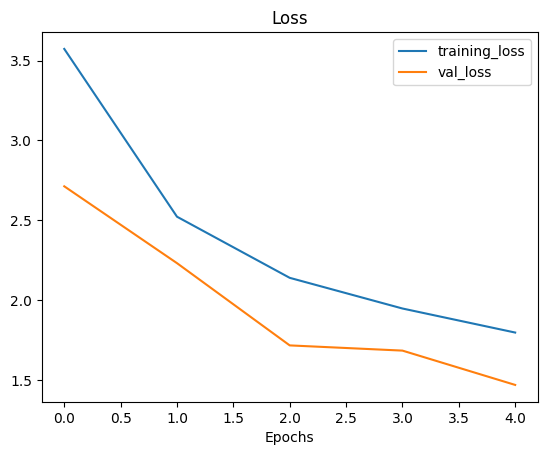

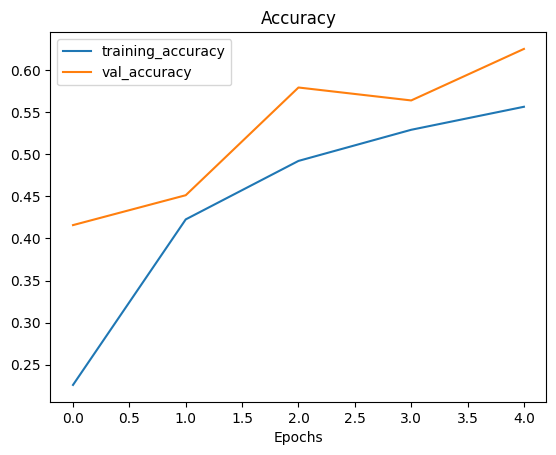

In [13]:
plot_loss_curves(history=history)

## Fine-tuning

In [14]:
# unfreeze all of the layers in the base_model

base_model.trainable = True

# Refreeze every layers except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [15]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ["accuracy"])

In [16]:
fine_tune_epochs = 6

history_fine_tune = model.fit(train_data_all_10_percent,
                              epochs = fine_tune_epochs,
                              validation_data = test_data,
                            #   steps_per_epoch = len(train_data_all_10_percent),
                              validation_steps = int(0.15*len(test_data)),
                              initial_epoch = history.epoch[-1],
                              callbacks = [checkpoint_callback]
                              )

Epoch 5/6
237/237 ━━━━━━━━━━━━━━━━━━━━ 1169s 5s/step - accuracy: 0.5568 - loss: 1.9517 - val_accuracy: 0.5167 - val_loss: 1.9702
Epoch 6/6
237/237 ━━━━━━━━━━━━━━━━━━━━ 1260s 5s/step - accuracy: 0.5960 - loss: 1.7666 - val_accuracy: 0.5445 - val_loss: 1.7036


### Kernel died after 4 epochs. Each epoch was taking 30 min. If i want to run this i also have to re-run the first model. Takes too long, so have to run on google colab. :(

### Now Google Colab doesn't let me use GPU, too much resources used already? ... so running history_fine_tune for 1 more epochs only (6-5).

In [17]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 237s 300ms/step - accuracy: 0.5505 - loss: 1.7563


[1.6394550800323486, 0.5727920532226562]

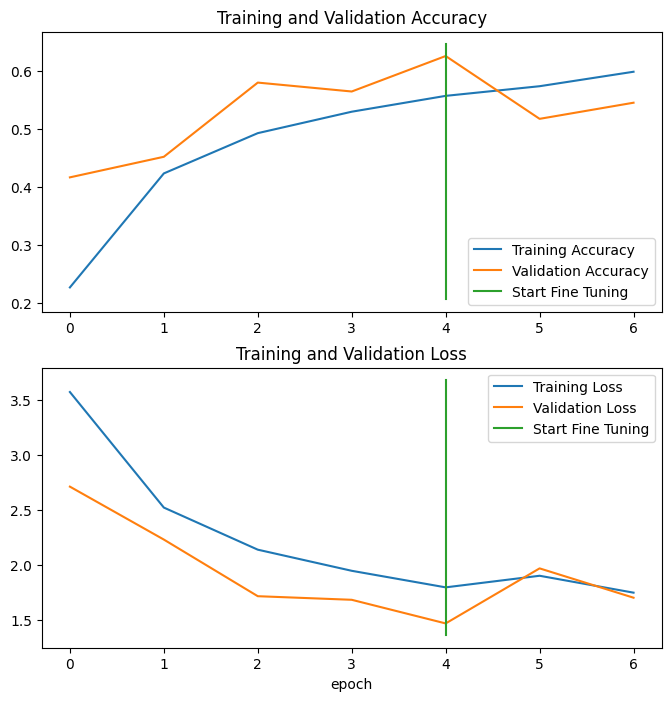

In [18]:
compare_historys(original_history = history,
                new_history = history_fine_tune,
                initial_epochs = 5)

## Saving and loading our model

In [2]:
import tensorflow as tf 
# since kernel crashed... again!

In [22]:
# Save our fine-tuned model
model.save("./models/101_food_classes/101_food_classes_10_percent_saved_big_dog_model.keras")

In [3]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("./models/101_food_classes/101_food_classes_10_percent_saved_big_dog_model.keras")
loaded_model

2024-08-08 00:28:53.057455: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-08 00:28:53.057479: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-08 00:28:53.057486: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-08 00:28:53.057504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-08 00:28:53.057517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<Functional name=functional_2, built=True>

In [11]:
# Evalluate loaded model and compare to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

2024-08-08 00:29:32.414742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


790/790 ━━━━━━━━━━━━━━━━━━━━ 100s 122ms/step - accuracy: 0.5505 - loss: 1.7563


[1.6394550800323486, 0.5727920532226562]

In [28]:
all_classes_10_percent_fine_tune_results == loaded_model_results

True

## Evaluating the "Big Dog" model across all different classes

In [ ]:
# This is the one from the tutorial, so we have the same model.
"https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip"

#### It was not possible to use normal code to open loaded model because tutorial uses other formats to save it and now kera 3 saves with .keras and opens models only with .keras or .h5 legacy models. But Chat-gpt helped me with this way to open model with the help of TSFMLayer. Not sure if it really works though:

In [61]:
# from keras.layers import TFSMLayer

# model_path = "/Users/alejandrocortes/Documents/Courses/Udemy Courses/Tensorflow_Course/tensorflow-deep-learning/06_101_food_class_10_percent_saved_big_dog_model"

# # Load the model to inspect its signatures and get the call endpoint
# loaded_model = tf.saved_model.load(model_path)
# print(loaded_model.signatures)  # Check the available endpoints

# # Assuming the endpoint is 'serving_default' (update if different)
# model = tf.keras.Sequential([
#     TFSMLayer(model_path, call_endpoint='serving_default')
# ])

_SignatureMap({'serving_default': <ConcreteFunction (*, input_22: TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_22')) -> Dict[['dense_8', TensorSpec(shape=(None, 101), dtype=tf.float32, name='dense_8')]] at 0x73042891E0>})


In [63]:
# didn't work... will go back to use my own model, not his model from the internet. (different versions of keras)

# Working with our own loaded model (local server) since downloading teacher's (tutorial) one does not work.

In [ ]:
# GO up and run the code for the training and test data

import tensorflow as tf

# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("./models/101_food_classes/101_food_classes_10_percent_saved_big_dog_model.keras")

In [14]:
loaded_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,804,097 (25.96 MB)

 Trainable params: 377,701 (1.44 MB)

 Non-trainable params: 5,670,992 (21.63 MB)

 Optimizer params: 755,404 (2.88 MB)

In [38]:
# Evalluate loaded model and compare to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 161s 203ms/step - accuracy: 0.5505 - loss: 1.7563


[1.6394550800323486, 0.5727920532226562]

## Making predictions with our trained model

In [15]:
# Make predictions with model

preds_probs = loaded_model.predict(test_data, verbose = 1) 

790/790 ━━━━━━━━━━━━━━━━━━━━ 136s 168ms/step


In [16]:
len(test_data), len(preds_probs)

(790, 25250)

In [17]:
preds_probs.shape

(25250, 101)

In [18]:
preds_probs[:10]

array([[4.97817528e-03, 8.31975020e-04, 6.26203865e-02, ...,
        1.63229692e-04, 5.62016480e-03, 8.82102235e-04],
       [2.37615332e-01, 1.11860296e-04, 1.62891522e-02, ...,
        6.98899524e-03, 2.07497054e-04, 2.02193740e-03],
       [1.57645017e-01, 1.01954816e-03, 1.24953026e-02, ...,
        3.91423143e-03, 2.29556276e-03, 1.87359611e-03],
       ...,
       [1.74222410e-01, 9.28791778e-05, 3.97520624e-02, ...,
        3.97685636e-03, 7.55211397e-04, 2.11889041e-03],
       [7.02115670e-02, 1.26442756e-03, 9.04180110e-02, ...,
        5.20713581e-03, 7.21364515e-04, 1.62307173e-03],
       [1.79463863e-01, 9.16536010e-05, 1.33217992e-02, ...,
        1.01479432e-02, 2.79635686e-04, 1.76632649e-03]], dtype=float32)

In [22]:
# What does the first prediction look like?

preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([4.9781753e-03, 8.3197502e-04, 6.2620386e-02, 4.3524768e-05,
        2.4904657e-04, 2.6800155e-03, 4.5587882e-04, 7.2602532e-04,
        1.5627996e-03, 6.7282268e-03, 2.4754199e-04, 4.3248598e-04,
        1.2664224e-03, 2.1623938e-04, 2.6589669e-02, 3.5031106e-02,
        5.9621381e-03, 2.5598397e-03, 4.5839278e-03, 4.1366429e-03,
        7.8308033e-03, 2.7162887e-04, 8.5346715e-04, 7.9583720e-04,
        1.5044274e-03, 1.5641520e-02, 3.9618923e-03, 2.5329232e-04,
        1.8037865e-02, 1.6774804e-03, 2.3354041e-04, 6.5803283e-04,
        1.9353375e-02, 2.3078977e-03, 3.9183185e-02, 4.9517542e-04,
        6.2993481e-03, 4.8061525e-03, 2.1338347e-02, 1.5393433e-03,
        3.7606079e-03, 3.4197029e-03, 4.3068422e-04, 1.7152410e-03,
        2.6924468e-03, 1.5647517e-03, 2.0893810e-03, 1.0510442e-03,
        6.2924542e-04, 1.4494188e-02, 2.1997914e-03, 2.0671021e-03,
        4.9855955e-02, 4.1168489e-02, 2.1850798e-04, 1.2816487e-02,
        5.3100199e-03, 2.2023197e-03, 2.8108979e

In [23]:
import numpy as np

In [25]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: {(preds_probs[0])}")
print(f"The class with highest prediction probability: {np.argmax(preds_probs[0])}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: [4.9781753e-03 8.3197502e-04 6.2620386e-02 4.3524768e-05 2.4904657e-04
 2.6800155e-03 4.5587882e-04 7.2602532e-04 1.5627996e-03 6.7282268e-03
 2.4754199e-04 4.3248598e-04 1.2664224e-03 2.1623938e-04 2.6589669e-02
 3.5031106e-02 5.9621381e-03 2.5598397e-03 4.5839278e-03 4.1366429e-03
 7.8308033e-03 2.7162887e-04 8.5346715e-04 7.9583720e-04 1.5044274e-03
 1.5641520e-02 3.9618923e-03 2.5329232e-04 1.8037865e-02 1.6774804e-03
 2.3354041e-04 6.5803283e-04 1.9353375e-02 2.3078977e-03 3.9183185e-02
 4.9517542e-04 6.2993481e-03 4.8061525e-03 2.1338347e-02 1.5393433e-03
 3.7606079e-03 3.4197029e-03 4.3068422e-04 1.7152410e-03 2.6924468e-03
 1.5647517e-03 2.0893810e-03 1.0510442e-03 6.2924542e-04 1.4494188e-02
 2.1997914e-03 2.0671021e-03 4.9855955e-02 4.1168489e-02 2.1850798e-04
 1.2816487e-02 5.3100199e-03 2.2023197e-03 2.8108979e-02 2.4658567e-04
 3.6835176e-05 6.3824970e-03 2.5932610e-03 2.2

In [28]:
test_data.class_names[85]

'samosa'

In [29]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([85,  0,  0,  0,  8, 78, 29, 46,  9, 41])

In [30]:
len(pred_classes)

25250

In [34]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently labels look like: [0, 0, 0, 0, ... 1, 0, 0,...., 0]
y_labels[:10]

2024-08-08 01:14:14.781583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [92]:
len(y_labels)

25250

## Evaluating our model's predictions

In [39]:
loaded_model_results

[1.6394550800323486, 0.5727920532226562]

In [41]:
# Let's try Scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true = y_labels,
                                y_pred = pred_classes)
sklearn_accuracy                                

0.5727920792079207

In [42]:
np.isclose(loaded_model_results[1], sklearn_accuracy)

True

## Let's get visual: Making Confusion Matrix

In [48]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_labels, pred_classes, test_data.class_names, figsize = (100,100), text_size = 20)

## Let's keep the evaluation metric going
Using Classification report from sklearn

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_true= y_labels, y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.39      0.17      0.23       250
           1       0.49      0.73      0.58       250
           2       0.73      0.46      0.56       250
           3       0.70      0.50      0.58       250
           4       0.62      0.34      0.44       250
           5       0.56      0.37      0.45       250
           6       0.69      0.76      0.73       250
           7       0.77      0.72      0.75       250
           8       0.29      0.45      0.35       250
           9       0.26      0.82      0.39       250
          10       0.58      0.41      0.48       250
          11       0.59      0.58      0.58       250
          12       0.75      0.53      0.62       250
          13       0.51      0.57      0.54       250
          14       0.44      0.64      0.52       250
          15       0.40      0.31      0.35       250
          16       0.70      0.47      0.56       250
          17       0.44    

In [60]:
# Get a dictionary of the classification report

classification_report_dict = classification_report(y_true= y_labels, y_pred = pred_classes, output_dict = True)
classification_report_dict

{'0': {'precision': 0.3853211009174312,
  'recall': 0.168,
  'f1-score': 0.233983286908078,
  'support': 250},
 '1': {'precision': 0.48533333333333334,
  'recall': 0.728,
  'f1-score': 0.5824,
  'support': 250},
 '2': {'precision': 0.7261146496815286,
  'recall': 0.456,
  'f1-score': 0.5601965601965602,
  'support': 250},
 '3': {'precision': 0.6966292134831461,
  'recall': 0.496,
  'f1-score': 0.5794392523364487,
  'support': 250},
 '4': {'precision': 0.6176470588235294,
  'recall': 0.336,
  'f1-score': 0.43523316062176165,
  'support': 250},
 '5': {'precision': 0.5636363636363636,
  'recall': 0.372,
  'f1-score': 0.44819277108433736,
  'support': 250},
 '6': {'precision': 0.6934306569343066,
  'recall': 0.76,
  'f1-score': 0.7251908396946566,
  'support': 250},
 '7': {'precision': 0.7735042735042735,
  'recall': 0.724,
  'f1-score': 0.7479338842975206,
  'support': 250},
 '8': {'precision': 0.2912371134020619,
  'recall': 0.452,
  'f1-score': 0.3542319749216301,
  'support': 250},
 '9

## Let's plot all of our classes F1-scores

In [56]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [67]:
# Create empty dictionary
class_f1_scores = {}

# Loop in the classification report dict items
for key, value in classification_report_dict.items():
    if key == 'accuracy': break
    else:
        class_f1_scores[class_names[int(key)]] = value['f1-score']

In [68]:
class_f1_scores

{'apple_pie': 0.233983286908078,
 'baby_back_ribs': 0.5824,
 'baklava': 0.5601965601965602,
 'beef_carpaccio': 0.5794392523364487,
 'beef_tartare': 0.43523316062176165,
 'beet_salad': 0.44819277108433736,
 'beignets': 0.7251908396946566,
 'bibimbap': 0.7479338842975206,
 'bread_pudding': 0.3542319749216301,
 'breakfast_burrito': 0.3915950334288443,
 'bruschetta': 0.48130841121495327,
 'caesar_salad': 0.5818181818181819,
 'cannoli': 0.6214953271028038,
 'caprese_salad': 0.5386064030131826,
 'carrot_cake': 0.522167487684729,
 'ceviche': 0.3484162895927602,
 'cheese_plate': 0.5625,
 'cheesecake': 0.37209302325581395,
 'chicken_curry': 0.44819277108433736,
 'chicken_quesadilla': 0.46913580246913583,
 'chicken_wings': 0.6923076923076924,
 'chocolate_cake': 0.5309381237524949,
 'chocolate_mousse': 0.37188208616780055,
 'churros': 0.7032967032967035,
 'clam_chowder': 0.7335766423357664,
 'club_sandwich': 0.5984848484848484,
 'crab_cakes': 0.40196078431372545,
 'creme_brulee': 0.69677419354838

In [71]:
# Sort the value in ascending order

import pandas as pd
f1_scores_pd = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                            "f1-scores": list(class_f1_scores.values())})

In [75]:
f1_scores_pd = f1_scores_pd.sort_values("f1-scores", ascending = False)
f1_scores_pd

class_names  f1-scores
33            edamame   0.926829
54  hot_and_sour_soup   0.838835
32          dumplings   0.831068
69            oysters   0.829960
63           macarons   0.820276
..                ...        ...
99       tuna_tartare   0.255875
93              steak   0.247978
77          pork_chop   0.238663
0           apple_pie   0.233983
39          foie_gras   0.196825

[101 rows x 2 columns]

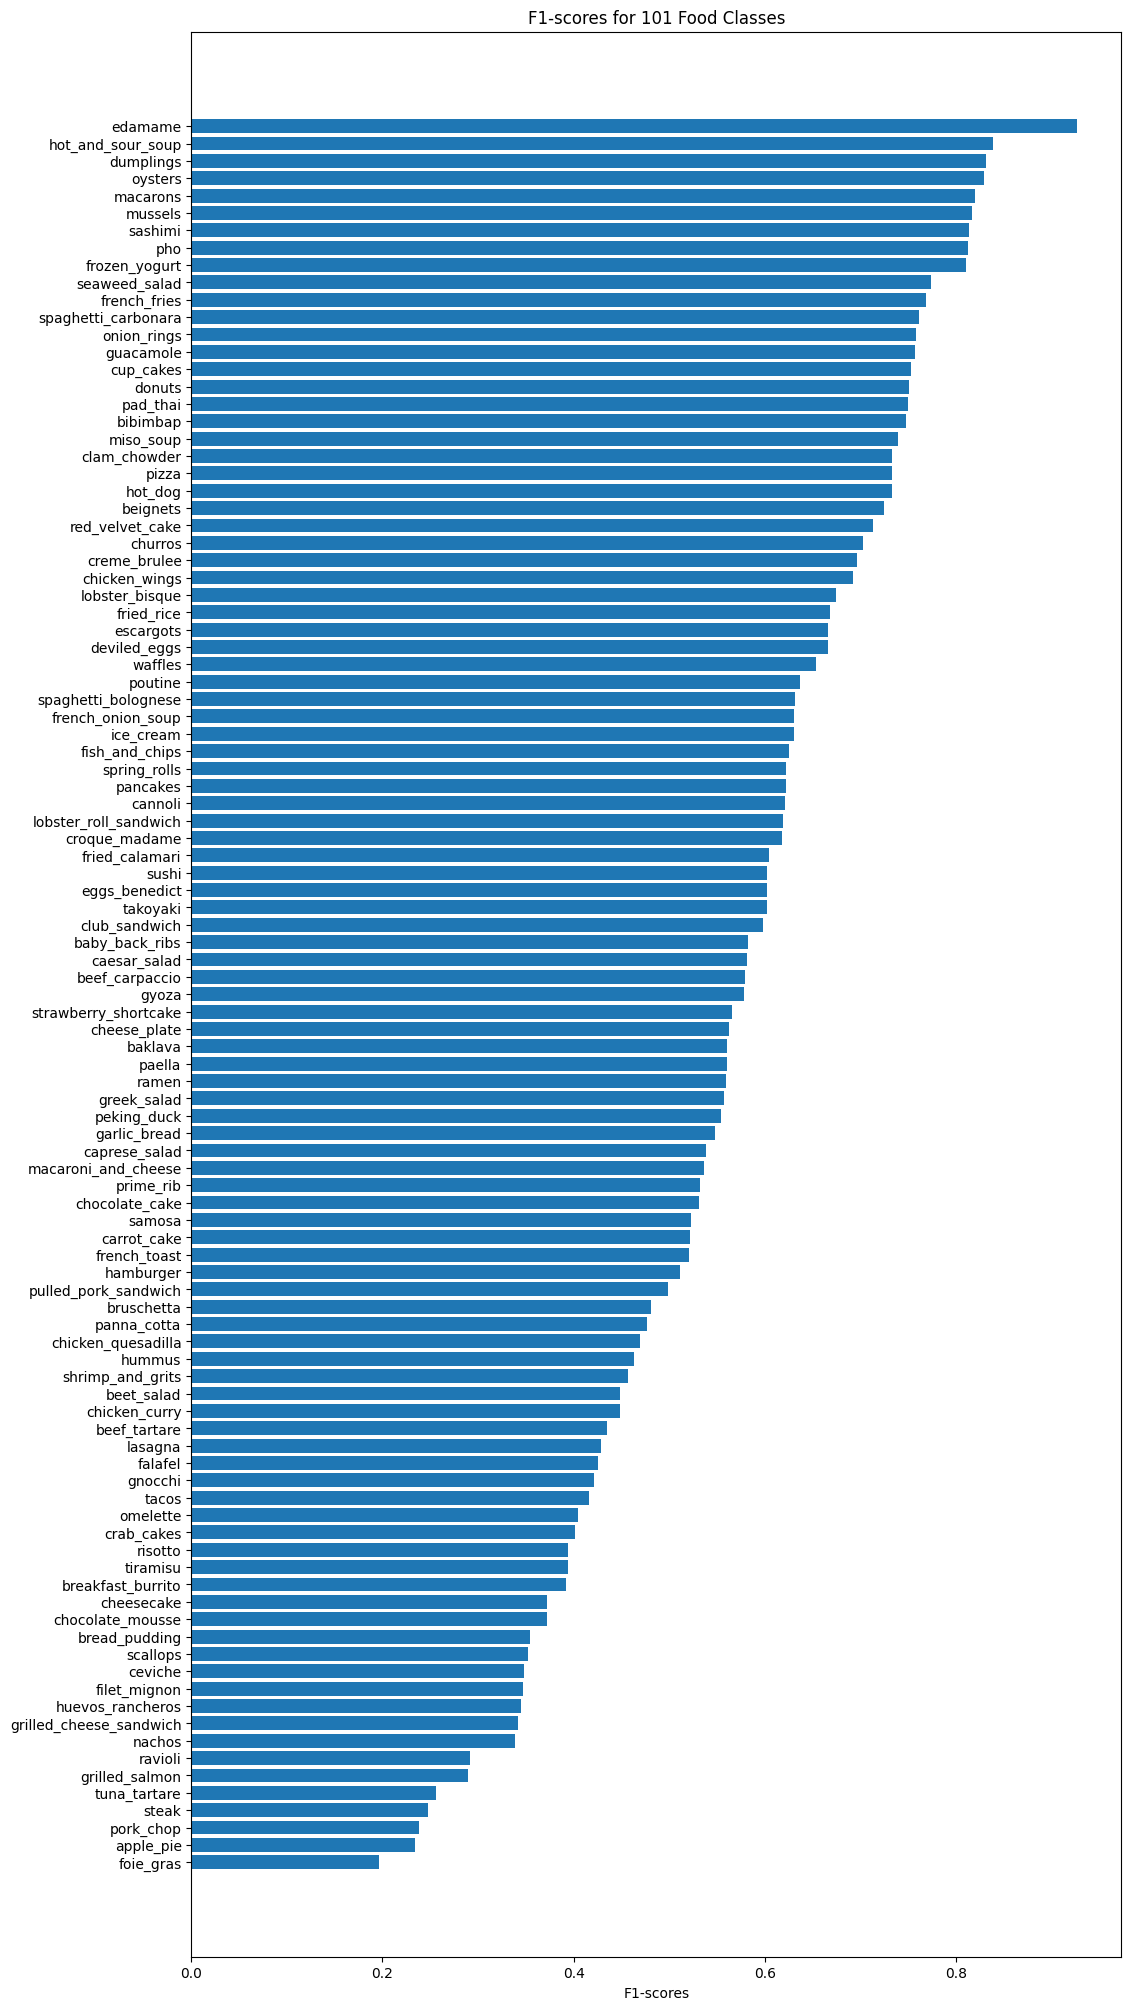

In [88]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(figsize=(12,25))
score = ax.barh(range(len(f1_scores_pd)), f1_scores_pd["f1-scores"].values)
ax.set_yticks(range(len(f1_scores_pd)))
ax.set_yticklabels(f1_scores_pd.class_names)
ax.set_xlabel("F1-scores")
ax.set_title("F1-scores for 101 Food Classes")
ax.invert_yaxis()

## Visualizing predictions on test images

In [139]:
import tensorflow as tf

# Create a function to load and prepare images
def load_and_prep_images(filename, img_shape=224, scale=True):
    """
    Reds in an image from filename, turns it into a tensor and reshapes into a specified shape
    (img_shape, img_shape, color_channels = 3).

    Args: 
        filename (str): path to the target image
        image_shape (txt): height/width dimensions of target image size
        scale (bool): scale pixel values from 0-255 to 0-1 or not

    Returns:
        IMage tensor of shape (img_shape, img_shape, 3)
    """

    # Read the image
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.io.decode_image(img, channels = 3)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    # Scale? Yes / No
    if scale:
        return img/255.
    else:
        return img # Do not need to rescale if using EfficientNet

In [140]:
# Code for visualizing images, target label, and our model's predictions.

# 1. Load a few random images from our dataset
# 2. Make predictions on the loaded images
# 3. Plot the original images(s) along with the model's predicitions, predictions probability and truth label

In [153]:
train_data_all_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

../Datasets/101_food_classes_10_percent/test/poutine/2498908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
../Datasets/101_food_classes_10_percent/test/bread_pudding/1005036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
../Datasets/101_food_classes_10_percent/test/waffles/1950857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


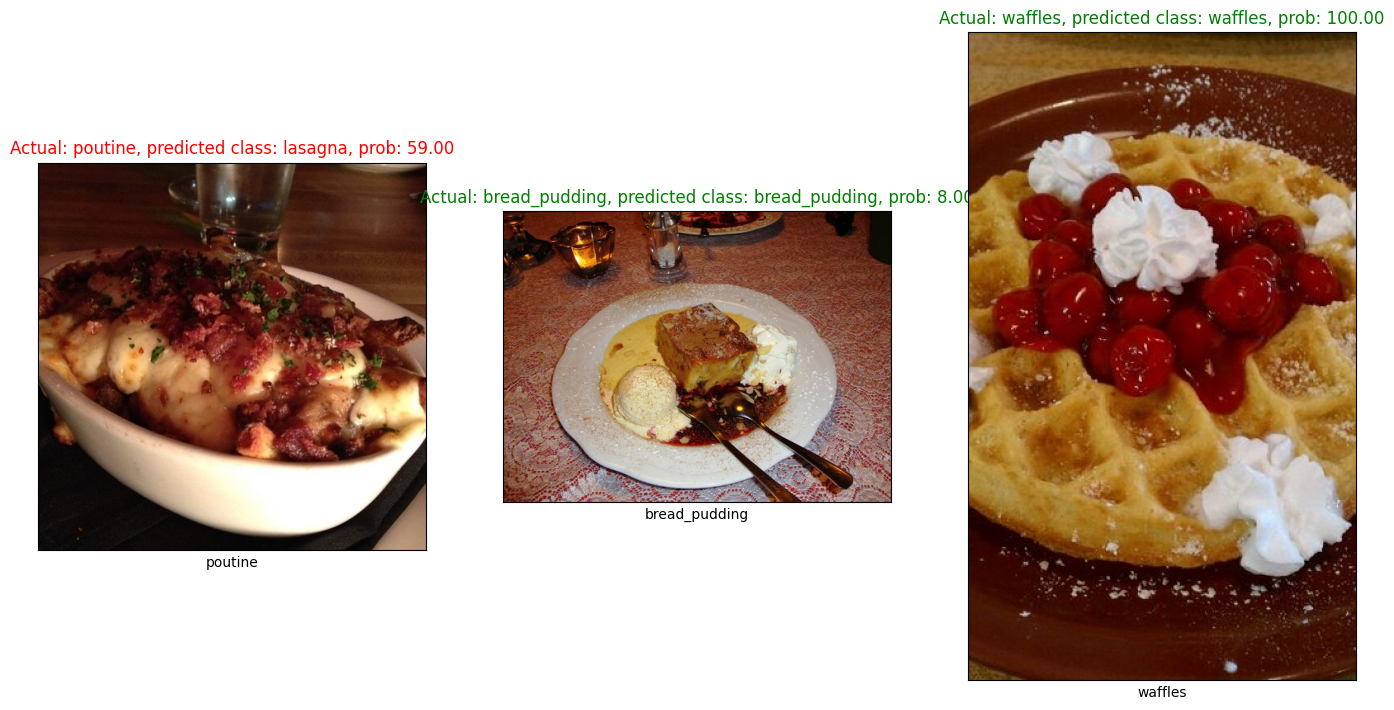

In [210]:
# Make predictions
import os
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.figure(figsize=(17,10))
for i in range(3):
    # Choose an image from a random class:
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(f"{test_dir}/{class_name}"))
    filepath = test_dir + "/" + class_name + "/" + filename
    print(filepath)

    # Load an image and make predictions
    img = load_and_prep_images(filepath, scale = False)
    img = tf.expand_dims(img, axis = 0) # They were not the same dimensions (after having an error)
    pred_prob = loaded_model.predict(img)
    pred_class = class_names[pred_prob.argmax()]
    # print(pred_prob)
    # print(pred_class)

    # Plot the image(s)
    plt.subplot(1,3,i+1)
    real_image = mpimg.imread(filepath)
    imgplot = plt.imshow(real_image)
    # plt.axis(False) # ERROR?, so then this:
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(class_name)
    if class_name == pred_class: title_color = 'g'
    else: title_color = 'r'
    plt.title(f"Actual: {class_name}, predicted class: {pred_class}, prob: {pred_prob.argmax():.2f}", c = title_color)
    

## Finding out the most wrong predictions

In [215]:
# Get all the image file paths
filepaths = []
for filepath in test_data.list_files("../Datasets/101_food_classes_10_percent/test/*/*.jpg", shuffle = False):
    filepaths.append(filepath.numpy())

2024-08-08 21:46:39.072125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [217]:
filepaths

[b'../Datasets/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/1113017.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/116705.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/1167170.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/1174330.jpg',
 b'../Datasets/101_food_classes_10_percent/test/apple_pie/1180600.jp

In [219]:
import pandas as pd

pred_df = pd.DataFrame({"image_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_class_name": [class_names[i] for i in y_labels],
                        "y_preds_class_name": [class_names[i] for i in pred_classes]
                        })

In [220]:
pred_df

image_path  y_true  y_pred  \
0      b'../Datasets/101_food_classes_10_percent/test...       0      85   
1      b'../Datasets/101_food_classes_10_percent/test...       0       0   
2      b'../Datasets/101_food_classes_10_percent/test...       0       0   
3      b'../Datasets/101_food_classes_10_percent/test...       0       0   
4      b'../Datasets/101_food_classes_10_percent/test...       0       8   
...                                                  ...     ...     ...   
25245  b'../Datasets/101_food_classes_10_percent/test...     100     100   
25246  b'../Datasets/101_food_classes_10_percent/test...     100     100   
25247  b'../Datasets/101_food_classes_10_percent/test...     100      56   
25248  b'../Datasets/101_food_classes_10_percent/test...     100      94   
25249  b'../Datasets/101_food_classes_10_percent/test...     100      23   

       pred_conf y_true_class_name    y_preds_class_name  
0       0.251713         apple_pie                samosa  
1       0.237615         apple_pie             apple_pie  
2       0.157645         apple_pie             apple_pie  
3       0.171924         apple_pie             apple_pie  
4       0.410413         apple_pie         bread_pudding  
...          ...               ...                   ...  
25245   0.696075           waffles               waffles  
25246   0.791103           waffles               waffles  
25247   0.315729           waffles      huevos_rancheros  
25248   0.143269           waffles  strawberry_shortcake  
25249   0.167242           waffles               churros  

[25250 rows x 6 columns]

In [221]:
# Find out in dataframe which predictions are wrong

pred_df["pred_correct"] = pred_df.y_true == pred_df.y_pred
pred_df

image_path  y_true  y_pred  \
0      b'../Datasets/101_food_classes_10_percent/test...       0      85   
1      b'../Datasets/101_food_classes_10_percent/test...       0       0   
2      b'../Datasets/101_food_classes_10_percent/test...       0       0   
3      b'../Datasets/101_food_classes_10_percent/test...       0       0   
4      b'../Datasets/101_food_classes_10_percent/test...       0       8   
...                                                  ...     ...     ...   
25245  b'../Datasets/101_food_classes_10_percent/test...     100     100   
25246  b'../Datasets/101_food_classes_10_percent/test...     100     100   
25247  b'../Datasets/101_food_classes_10_percent/test...     100      56   
25248  b'../Datasets/101_food_classes_10_percent/test...     100      94   
25249  b'../Datasets/101_food_classes_10_percent/test...     100      23   

       pred_conf y_true_class_name    y_preds_class_name  pred_correct  
0       0.251713         apple_pie                samosa         False  
1       0.237615         apple_pie             apple_pie          True  
2       0.157645         apple_pie             apple_pie          True  
3       0.171924         apple_pie             apple_pie          True  
4       0.410413         apple_pie         bread_pudding         False  
...          ...               ...                   ...           ...  
25245   0.696075           waffles               waffles          True  
25246   0.791103           waffles               waffles          True  
25247   0.315729           waffles      huevos_rancheros         False  
25248   0.143269           waffles  strawberry_shortcake         False  
25249   0.167242           waffles               churros         False  

[25250 rows x 7 columns]

In [225]:
# Sort the DF to have the most wrong predictions at the top

top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)[0:100]
top_100_wrong

image_path  y_true  y_pred  \
23797  b'../Datasets/101_food_classes_10_percent/test...      95      86   
14482  b'../Datasets/101_food_classes_10_percent/test...      57      51   
4836   b'../Datasets/101_food_classes_10_percent/test...      19       9   
5998   b'../Datasets/101_food_classes_10_percent/test...      23      68   
2030   b'../Datasets/101_food_classes_10_percent/test...       8      41   
...                                                  ...     ...     ...   
21315  b'../Datasets/101_food_classes_10_percent/test...      85      68   
8888   b'../Datasets/101_food_classes_10_percent/test...      35      76   
4457   b'../Datasets/101_food_classes_10_percent/test...      17      94   
24092  b'../Datasets/101_food_classes_10_percent/test...      96       9   
22744  b'../Datasets/101_food_classes_10_percent/test...      90      91   

       pred_conf    y_true_class_name    y_preds_class_name  pred_correct  
23797   0.979236                sushi               sashimi         False  
14482   0.967431               hummus             guacamole         False  
4836    0.967124   chicken_quesadilla     breakfast_burrito         False  
5998    0.956525              churros           onion_rings         False  
2030    0.955293        bread_pudding     french_onion_soup         False  
...          ...                  ...                   ...           ...  
21315   0.842272               samosa           onion_rings         False  
8888    0.842007            escargots                 pizza         False  
4457    0.841084           cheesecake  strawberry_shortcake         False  
24092   0.840678                tacos     breakfast_burrito         False  
22744   0.840541  spaghetti_bolognese   spaghetti_carbonara         False  

[100 rows x 7 columns]

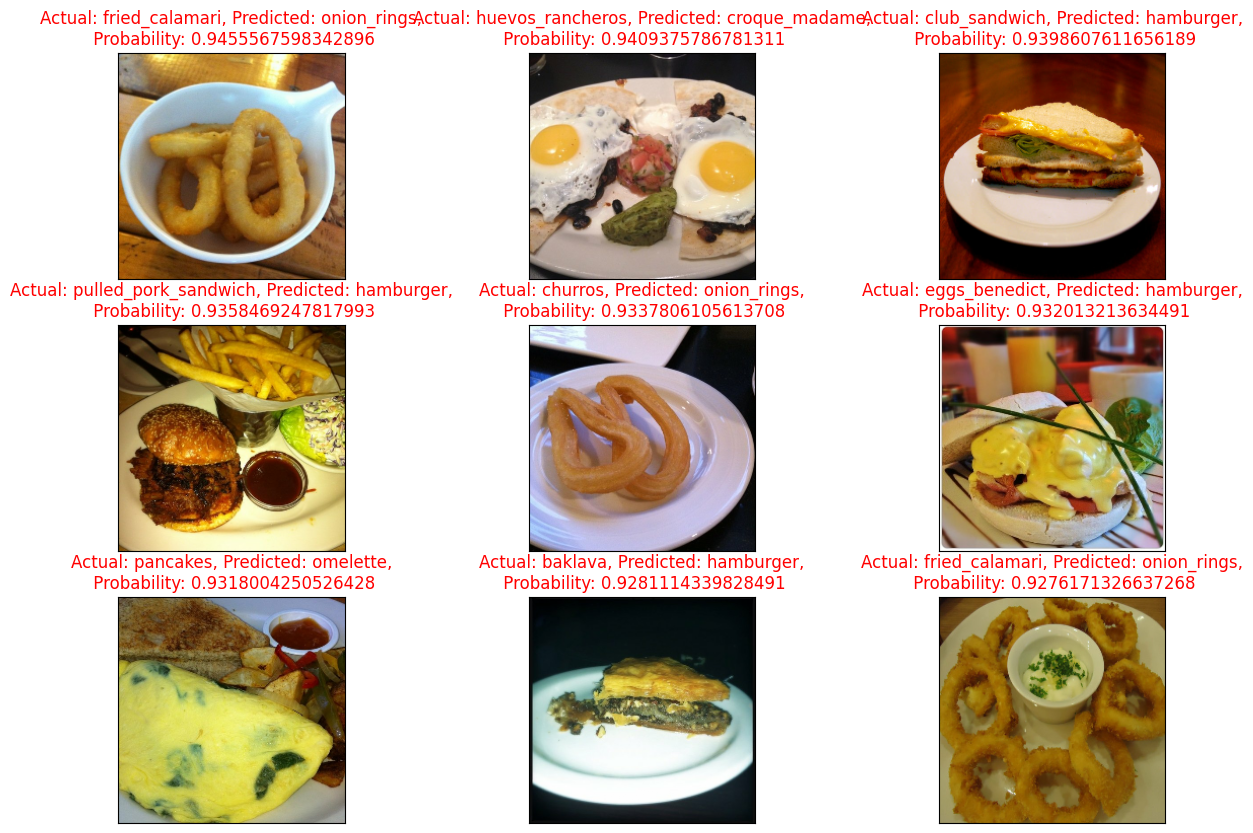

In [249]:
# Visualize the test data sample which have the most wrong prediction but highest pred probability
images_to_view = 9
start_index = 10
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index: start_index + images_to_view].itertuples()):
    plt.subplot(3,3,i+1)
    img = load_and_prep_images(row[1], scale = False) #row[1] is the image_path from DF
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
    plt.imshow(img/255.)
    if y_true_classname == y_pred_classname: title_color = 'g'
    else: title_color = 'r'
    plt.title(f"Actual: {y_true_classname}, Predicted: {y_pred_classname},\n Probability: {pred_prob}", c = title_color)
    plt.yticks([])
    plt.xticks([])

## Test out the model on our own custom images

In [250]:
# Get custom images

custom_food_images = ["../custom_food_images/" + path for path in os.listdir("../custom_food_images/")]
custom_food_images

['../custom_food_images/hamburger.jpeg',
 '../custom_food_images/steak.jpeg',
 '../custom_food_images/sushi.jpeg',
 '../custom_food_images/chicken_wings.jpeg',
 '../custom_food_images/ramen.jpeg',
 '../custom_food_images/pizza-dad.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


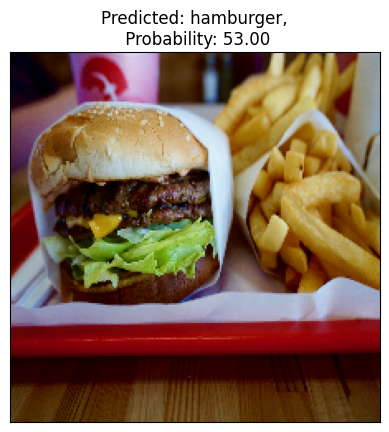

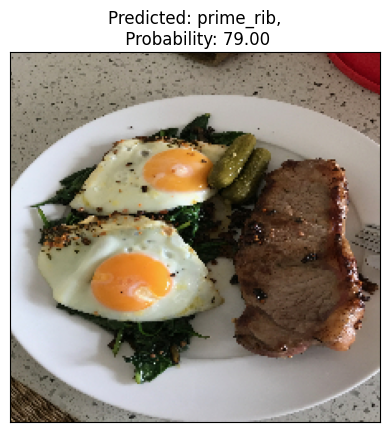

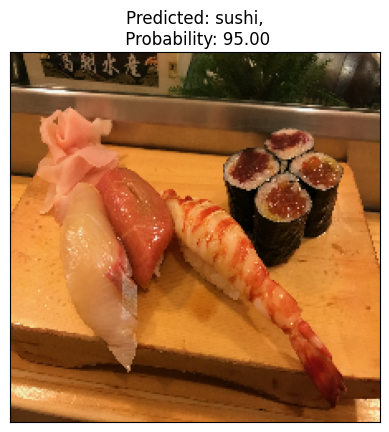

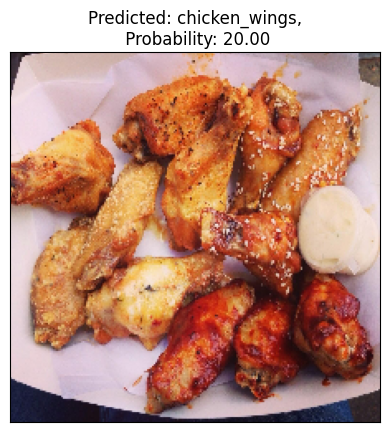

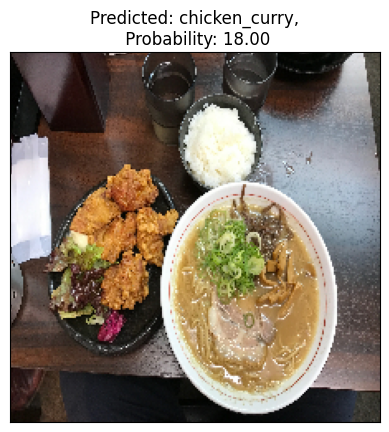

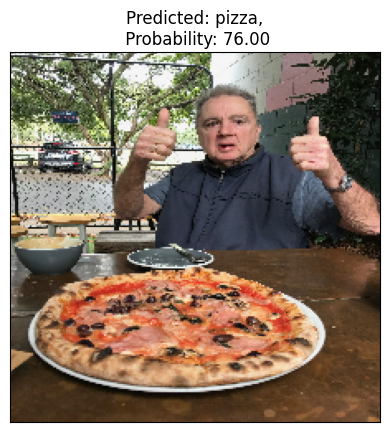

In [262]:
# Make predictions and plot custom food images

for img in custom_food_images:
    img = load_and_prep_images(img, scale = False)
    pred_prob =  loaded_model.predict(tf.expand_dims(img, axis = 0))
    pred_class = class_names[pred_prob.argmax()]
    
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"Predicted: {pred_class},\n Probability: {pred_prob.argmax():.2f}")
    plt.xticks([])
    plt.yticks([])

# FINISHED!!!